In [1]:
from imports import *
from utils import *
from tfms_torch import *
from tfms_albumentations import get_tfms_albu, apply_tfms_albu
from video_dataset import *
from samplers import *

# Vanilla PyTorch w/LRFinder

## Create Training and Validation Datasets

In [2]:
data_dir = Path('/home/rahul/datasets/tennis-func/')
cache_dir = data_dir/'.cache'

In [3]:
cache_dir.ls()

['train-metrics',
 'train_fpc-32_sc-1_sf-2_rsz-2',
 'valid_fpc-32_sc-1_sf-2_rsz-2']

In [4]:
train_data = torch.load(cache_dir/'train_fpc-32_sc-1_sf-2_rsz-2')
valid_data = torch.load(cache_dir/'valid_fpc-32_sc-1_sf-2_rsz-2')

In [5]:
def get_data(data_dir, fpclip=32, step_clips=1, frame_stride=2, rsz_fct=2, albu_p=0.5):
    train_data = VideoDataset(
        data_dir/'train',
        frames_per_clip    = fpclip,
        step_between_clips = step_clips,
        frame_stride = frame_stride,
        tfms_torch   = get_tfms_torch(resize_fct=rsz_fct),
        tfms_albu    = get_tfms_albu(p=albu_p)
    )
    valid_data = VideoDataset(
        data_dir/'valid',
        frames_per_clip    = fpclip,
        step_between_clips = step_clips,
        frame_stride = frame_stride,
        tfms_torch   = get_tfms_torch(resize_fct=rsz_fct)
    )
    return train_data, valid_data

## Data Loaders

In [6]:
from torch.utils.data import DataLoader as DataLoader

In [7]:
train_sampler = FirstClipSampler(train_data.video_clips, 2)
valid_sampler = FirstClipSampler(valid_data.video_clips, 2)
bs = 2

In [8]:
def get_dls(train_data, valid_data,
            train_sampler=FirstClipSampler(train_data.video_clips, 2),
            valid_sampler=FirstClipSampler(valid_data.video_clips, 2),
            bs=32, collate_fn=collate_fn):
    
    train_dl = DataLoader(train_data, batch_size=bs, sampler=train_sampler, collate_fn=collate_fn)
    valid_dl = DataLoader(valid_data, batch_size=bs, sampler=valid_sampler, collate_fn=collate_fn)
    
    return train_dl, valid_dl

In [9]:
train_dl, valid_dl = get_dls(train_data, valid_data, bs=bs)

In [10]:
x,y = next(iter(train_dl))
x.shape, y.shape

/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


(torch.Size([2, 3, 16, 256, 454]), torch.Size([2]))

## LR Finder

In [11]:
from torch_lr_finder import LRFinder, AccumulationLRFinder

/home/rahul/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [12]:
model = torchvision.models.video.r2plus1d_18(pretrained=True).cuda()
#model = model.half()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-2)

In [14]:
real_bs = 2
acc_bs = 12
acc_steps = acc_bs // real_bs

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


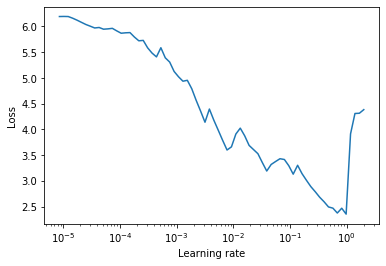

In [16]:
lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder.range_test(train_dl, end_lr=10, num_iter=90)
lr_finder.plot()
lr_finder.reset()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


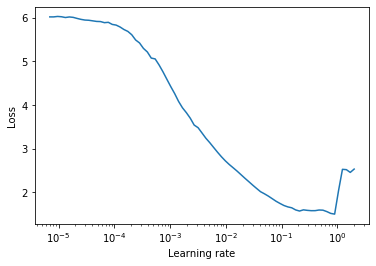

In [15]:
lr_finder = AccumulationLRFinder(model, optimizer, criterion, device='cuda', accumulation_steps=acc_steps)
lr_finder.range_test(train_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


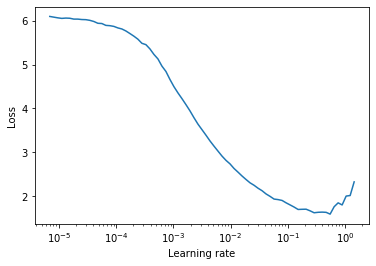

In [19]:
from apex import amp
model, optimizer = amp.initialize(model, optimizer)

lr_finder = AccumulationLRFinder(model, optimizer, criterion, device='cuda', accumulation_steps=acc_steps)
lr_finder.range_test(train_dl, end_lr=10, num_iter=100, step_mode='exp')
lr_finder.plot()
lr_finder.reset()

In [23]:
torch.cuda.empty_cache()

## Vanilla PyTorch Training

### Helper Functions

In [30]:
from visionmod import train_utils as utils
import datetime
import time

In [31]:
def train_one_epoch(model, criterion, optimizer, lr_scheduler, data_loader, device, epoch, print_freq, apex=False):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value}'))
    metric_logger.add_meter('clips/s', utils.SmoothedValue(window_size=10, fmt='{value:.3f}'))

    header = 'Epoch: [{}]'.format(epoch)
    for video, target in metric_logger.log_every(data_loader, print_freq, header):
        start_time = time.time()
        video, target = video.to(device), target.to(device)
        output = model(video)
        loss = criterion(output, target)

        optimizer.zero_grad()
        if apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        optimizer.step()

        acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
        batch_size = video.shape[0]
        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
        metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
        metric_logger.meters['clips/s'].update(batch_size / (time.time() - start_time))
        lr_scheduler.step()

In [32]:
def evaluate(model, criterion, data_loader, device):
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    with torch.no_grad():
        for video, target in metric_logger.log_every(data_loader, 100, header):
            video = video.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(video)
            loss = criterion(output, target)

            acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            batch_size = video.shape[0]
            metric_logger.update(loss=loss.item())
            metric_logger.meters['acc1'].update(acc1.item(), n=batch_size)
            metric_logger.meters['acc5'].update(acc5.item(), n=batch_size)
    # gather the stats from all processes
    metric_logger.synchronize_between_processes()

    print(' * Clip Acc@1 {top1.global_avg:.3f} Clip Acc@5 {top5.global_avg:.3f}'
          .format(top1=metric_logger.acc1, top5=metric_logger.acc5))
    return metric_logger.acc1.global_avg

### Training

In [33]:
lr=1e-2
optim = torch.optim.Adam(model.parameters(), lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optim, max_lr=5e-1, steps_per_epoch=len(train_dl), epochs=1
)

device = torch.device('cuda')

In [34]:
metrics_dir = cache_dir/'train-metrics'

In [35]:
start_time = time.time()

for epoch in range(10):
    train_one_epoch(model, criterion, optim, lr_scheduler, train_dl, device, epoch, print_freq=100)
    evaluate(model, criterion, valid_dl, device)
    checkpoint = {
        'model': model_without_ddp.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'epoch': epoch,
        'args': args}
    utils.save_on_master(
        checkpoint,
        os.path.join(str(metrics_dir), 'model_{}.pth'.format(epoch)))
    utils.save_on_master(
        checkpoint,
        os.path.join(str(metrics_dir), 'checkpoint.pth'))
    
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

Epoch: [0]  [   0/2229]  eta: 2:03:16  lr: 0.020000000000000018  clips/s: 1.124  loss: 5.7354 (5.7354)  acc1: 0.0000 (0.0000)  acc5: 0.0000 (0.0000)  time: 3.3184  data: 1.5394  max mem: 9516


KeyboardInterrupt: 

In [36]:
torch.cuda.empty_cache()

# PyTorch Lightning Training

In [2]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.nn import functional as F

In [3]:
data_dir = Path('/home/rahul/datasets/tennis-func//')
cache_dir = data_dir/'.cache'

In [4]:
train_data = torch.load(cache_dir/'train_fpc-32_sc-1_sf-2_rsz-2')
valid_data = torch.load(cache_dir/'valid_fpc-32_sc-1_sf-2_rsz-2')

In [5]:
class VideoClassification(pl.LightningModule):
    def __init__(self):
        super(VideoClassification, self).__init__()
        self.model = torchvision.models.video.r2plus1d_18(pretrained=True)
        
    def forward(self, x):
        return self.model.forward(x)
    
    def training_step(self, batch, batch_nb):
        x,y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}
    
    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self.forward(x)
        pred_class = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y == pred_class).item() / (len(y) * 1.)
        return {'val_loss': F.cross_entropy(y_hat, y),
                'val_accuracy': torch.tensor(val_acc)}
    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_accuracy = torch.stack([x['val_accuracy'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss,
                            'val_accuracy': avg_accuracy}
        return {'avg_val_loss': avg_loss,
                'avg_val_accuracy': avg_accuracy,
                'log': tensorboard_logs}
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.model.parameters(), lr=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optim, max_lr=5e-1, epochs=1,
            steps_per_epoch=len(self.train_dataloader())
        )
        return [optim], [lr_scheduler]
    
    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(train_data, batch_size=2,
                                           sampler=FirstClipSampler(train_data.video_clips, 1),
                                           collate_fn=collate_fn)
    @pl.data_loader
    def val_dataloader(self):
        return torch.utils.data.DataLoader(valid_data, batch_size=2,
                                           sampler=FirstClipSampler(valid_data.video_clips, 1),
                                           collate_fn=collate_fn)

In [6]:
model = VideoClassification()
trainer = Trainer(gpus=[0],use_amp=True, accumulate_grad_batches=16,
                  max_nb_epochs=5, row_log_interval=10)

In [7]:
trainer.fit(model)

Validation sanity check:   0%|          | 0/5 [00:00<?, ?batch/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/home/rahul/anaconda3/lib/python3.7/site-packages/torchvision/io/video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +
Epoch 1:   5%|▍         | 64/1285 [02:41<46:56,  2.31s/batch, batch_nb=63, gpu=0, loss=3.646, v_nb=1]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


Epoch 1:  93%|█████████▎| 1193/1285 [50:27<02:22,  1.55s/batch, batch_nb=1117, gpu=0, loss=1.015, v_nb=1]


Epoch 1:  99%|█████████▉| 1270/1285 [52:37<00:24,  1.63s/batch, batch_nb=1117, gpu=0, loss=1.015, v_nb=1]


Epoch 1: 100%|██████████| 1285/1285 [53:03<00:00,  1.71s/batch, batch_nb=1117, gpu=0, loss=1.015, v_nb=1]
                                                                /home/rahul/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch 2:  91%|█████████▏| 1173/1285 [50:02<03:06,  1.67s/batch, batch_nb=1117, gpu=0, loss=0.727, v_nb=1]


Epoch 2:  97%|█████████▋| 1250/1285 [52:13<01:01,  1.76s/batch, batch_nb=1117, gpu=0, loss=0.727, v_nb=1]


Epoch 3:  90%|█████████ | 1158/1285 [50:02<03:44,  1.76s/batch, batch_nb=1117, gpu=0, loss=0.704, v_nb=1]


Epoch 3:  96%|█████████▌| 1235/1285 [52:13<01:24,  1.70s/batch, batch_nb=1117, gpu=0, loss=0.704, v_nb=1]


Epoch 4:  89%|████████▉ | 1143/1285 [49:05<03:41,  1.56s/batch, batch_nb=1117, gpu=0, loss=0.696, v_nb=1]


Epoch 4:  95%|█████████▍| 1220/1285 [51:11<01:48,  1.67s/batch, batch_nb=1117, gpu=0, loss=0.696, v_nb=1]


Epoch 5:  15%|█▌        | 199/1285 [08:32<47:42,  2.64s/batch, batch_nb=198, gpu=0, loss=0.697, v_nb=1]  

KeyboardInterrupt: 

In [13]:
model.logger()